# Data Wrangling with all Tasks - DV Level
Starting point:
- 848 datasets (18 tasks per model (minus the NON_IDEAL_OUTPUTS)) with all logprobs for all answer alternatives of each subtask for all ~1.500 participants. 

Goal:
- find out and load DV for each participant
- calculate overall probability LLM assigns to participant
- weigh participants' DV with averaged probability, get DV per model per task
- Have 36 values per model! (one per (sub-) scale).

## Packages & Helpers

In [161]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from utils import load_dataframes, filter_pred_prob


In [162]:
# read human survey DV level data
survey_human_data = pd.read_csv("orig_human_data/quest_scores.csv")
survey_human_data.columns

Index(['partid', 'ses', 'ses_moth', 'ses_fath', 'famstat', 'sibl', 'sibl_y',
       'sibl_o', 'birthrank', 'edu', 'household', 'birthplace', 'income',
       'location', 'AUDIT', 'FTND', 'GABS', 'PG', 'DAST', 'NUM', 'SOEP',
       'SOEPdri', 'SOEPfin', 'SOEPrec', 'SOEPocc', 'SOEPhea', 'SOEPsoc',
       'CAREaggr', 'CAREsex', 'CAREwork', 'Deth', 'Dinv', 'Dgam', 'Dhea',
       'Drec', 'Dsoc', 'Deth_r', 'Dinv_r', 'Dgam_r', 'Dhea_r', 'Drec_r',
       'Dsoc_r', 'Deth_b', 'Dinv_b', 'Dgam_b', 'Dhea_b', 'Drec_b', 'Dsoc_b',
       'Dy', 'Dm', 'PRI', 'PRIw', 'BIS1att', 'BIS1mot', 'BIS1ctr', 'BIS1com',
       'BIS1per', 'BIS1ins', 'BIS2att', 'BIS2mot', 'BIS2npl', 'BIS', 'SStas',
       'SSexp', 'SSdis', 'SSbor', 'SSSV', 'BMI'],
      dtype='object')

In [163]:
# Helpers

# ----------------------------------------------------------------------------------------------
# Pro Modell × Item die Zähler und Nenner berechnen
# ----------------------------------------------------------------------------------------------
# - Zähler = Summe von (Antwort * Wahrscheinlichkeit)
# - Nenner = Summe von (Wahrscheinlichkeiten)

def compute_weighted_score(group):
    numerator = (group["human_number"] * group["prob_pred"]).sum()
    denominator = group["prob_pred"].sum()
    return numerator / denominator if denominator > 0 else None


# Funktion für Top-n gewichteten Score
def compute_top_n_weighted_score(group, n = 100):
    # Sortiere die Zeilen nach Wahrscheinlichkeit absteigend
    top_n = group.sort_values("prob_pred", ascending=False).head(n)
    # Numerator = Summe von (Antwort * Wahrscheinlichkeit)
    numerator = (top_n["human_number"] * top_n["prob_pred"]).sum()
    # Denominator = Summe von Wahrscheinlichkeiten der Top n
    denominator = top_n["prob_pred"].sum()
    return numerator / denominator if denominator > 0 else None

# produce df with one value per model per item --------------------------------------------------
# more compact version (that runs faster)
def get_LLM_value_per_item(data):
    grouped = data.groupby(["experiment", "model", "item"])
    score = (grouped["human_number"].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum())
             / grouped["prob_pred"].sum())
    return score.reset_index(name="score")

# produce df with one value per model per item for top n version --------------------------------------------------
def get_LLM_value_per_item_top_n(data):
    new_df = (
    data.groupby(["experiment", "model", "item"])[["human_number", "prob_pred"]]
      .apply(compute_top_n_weighted_score)
      .reset_index(name="score_top_n")
    )
    return(new_df)


# filter out probability LLM assigned to real item answer  ------------------------------------------
def filter_pred_prob_including_key_logic(data, key1_column="box_1_key", key2_column= "box_2_key"):
    # Determine whether the human decision matches box_1 or box_2
    mask_box1 = data["human_decision"] == data[key1_column]
    mask_box2 = data["human_decision"] == data[key2_column]

    # Assign probability based on which box matches
    data["prob_pred"] = data["prob_1"].where(mask_box1, data["prob_2"].where(mask_box2, None))
    
    return data

def get_LLM_value_per_item_aggregated(data, dv = "pumps"):
    grouped = data.groupby(["experiment", "model"])
    score = (grouped[dv].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum())
             / grouped["prob_pred"].sum())
    return score.reset_index(name="score")

def calc_one_DV_per_task(data, human_data, dv = "pumps"):
    # calculate avg probability per participant
    avg_prob_per_participant = data.groupby(["experiment", "model", "participant"])["prob_pred"].mean().reset_index()
    # merge human DV with probability per participant on participant
    avg_prob_per_participant = pd.merge(avg_prob_per_participant, 
                                        human_data[["partid", dv]], 
                                        left_on="participant",
                                        right_on="partid",
                                        how = "inner")
    # weigh DV by probability assigned per participant
    result = get_LLM_value_per_item_aggregated(avg_prob_per_participant, dv = dv)
    return result


# -------- aggregate to one DF per category function ------------------
def get_LLM_value_per_item_aggregated_categorywise(data, dv = "pumps"):
    grouped = data.groupby(["category", "model"])
    score = (grouped[dv].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum())
             / grouped["prob_pred"].sum())
    return score.reset_index(name="score")

def calc_one_DV_per_task_categorywise(data, human_data, dv = "pumps"):
    # calculate avg probability per participant
    avg_prob_per_participant = data.groupby(["category", "model", "participant"])["prob_pred"].mean().reset_index()
    # merge human DV with probability per participant on participant
    avg_prob_per_participant = pd.merge(avg_prob_per_participant, 
                                        human_data[["partid", dv]], 
                                        left_on="participant",
                                        right_on="partid",
                                        how = "inner")
    # weigh DV by probability assigned per participant
    result = get_LLM_value_per_item_aggregated_categorywise(avg_prob_per_participant, dv = dv)
    return result

def wrapper_for_categories(data, map_cat_names_to_DVs):
    i = 0
    for category in data["category"].unique():
        cat_data = data[data["category"] == category]
        cat_results = calc_one_DV_per_task_categorywise(data = cat_data, human_data = survey_human_data, dv = map_cat_names_to_DVs[category])
        if i == 0:
            out = cat_results[["model", "score"]].rename(columns={"score": category})
        else:
            out = pd.merge(out, cat_results[["model", "score"]].rename(columns={"score": category}), on=["model"], how="inner")
        i += 1
    return out
   



## Tasks

### AUDIT SCALE

In [164]:
# load data
AUDIT_data = load_dataframes(task_name="AUDIT", path = "LLM_data")

# normalise answer option sum to one (tun so als hätten wir sehr guten Prompt, dann würde LLM nur zwischen möglichen Antwortalternativen aussuchen, da simulieren wir dadurch)
mask = (AUDIT_data["item"] == 1)
AUDIT_data.loc[mask, "prob_1"] = np.exp(AUDIT_data.loc[mask, "1"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]))
AUDIT_data.loc[mask, "prob_2"] = np.exp(AUDIT_data.loc[mask, "2"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]))

mask = (AUDIT_data["item"].isin([10, 11]))
AUDIT_data.loc[mask, "prob_1"] = np.exp(AUDIT_data.loc[mask, "1"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]) + np.exp(AUDIT_data.loc[mask, "3"]))
AUDIT_data.loc[mask, "prob_2"] = np.exp(AUDIT_data.loc[mask, "2"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]) + np.exp(AUDIT_data.loc[mask, "3"]))
AUDIT_data.loc[mask, "prob_3"] = np.exp(AUDIT_data.loc[mask, "3"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]) + np.exp(AUDIT_data.loc[mask, "3"]))


mask = (AUDIT_data["item"].isin([2, 3, 4, 5, 6, 7, 8, 9]))
AUDIT_data.loc[mask, "prob_1"] = np.exp(AUDIT_data.loc[mask, "1"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]) + np.exp(AUDIT_data.loc[mask, "3"]) + np.exp(AUDIT_data.loc[mask, "4"]) + np.exp(AUDIT_data.loc[mask, "5"]))
AUDIT_data.loc[mask, "prob_2"] = np.exp(AUDIT_data.loc[mask, "2"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]) + np.exp(AUDIT_data.loc[mask, "3"]) + np.exp(AUDIT_data.loc[mask, "4"]) + np.exp(AUDIT_data.loc[mask, "5"]))
AUDIT_data.loc[mask, "prob_3"] = np.exp(AUDIT_data.loc[mask, "3"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]) + np.exp(AUDIT_data.loc[mask, "3"]) + np.exp(AUDIT_data.loc[mask, "4"]) + np.exp(AUDIT_data.loc[mask, "5"]))
AUDIT_data.loc[mask, "prob_4"] = np.exp(AUDIT_data.loc[mask, "4"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]) + np.exp(AUDIT_data.loc[mask, "3"]) + np.exp(AUDIT_data.loc[mask, "4"]) + np.exp(AUDIT_data.loc[mask, "5"]))
AUDIT_data.loc[mask, "prob_5"] = np.exp(AUDIT_data.loc[mask, "5"])/(np.exp(AUDIT_data.loc[mask, "1"]) + np.exp(AUDIT_data.loc[mask, "2"]) + np.exp(AUDIT_data.loc[mask, "3"]) + np.exp(AUDIT_data.loc[mask, "4"]) + np.exp(AUDIT_data.loc[mask, "5"]))

# filter out probability LLM assigned to real item answer 
AUDIT_data=filter_pred_prob(AUDIT_data)

# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_AUDIT_aggregated = calc_one_DV_per_task(data = AUDIT_data, human_data = survey_human_data, dv = "AUDIT")


Merged DataFrame shape: (712264, 11)
Total models: 46


### BARRAT SCALE

In [165]:
# load data
BARRAT_data = load_dataframes(task_name="BARRAT", path = "LLM_data")

# normalise answer option sum to one
BARRAT_data["prob_1"] = np.exp(BARRAT_data["1"])/(np.exp(BARRAT_data["1"]) + np.exp(BARRAT_data["2"]) + np.exp(BARRAT_data["3"]) + np.exp(BARRAT_data["4"]))
BARRAT_data["prob_2"] = np.exp(BARRAT_data["2"])/(np.exp(BARRAT_data["1"]) + np.exp(BARRAT_data["2"]) + np.exp(BARRAT_data["3"]) + np.exp(BARRAT_data["4"]))
BARRAT_data["prob_3"] = np.exp(BARRAT_data["3"])/(np.exp(BARRAT_data["1"]) + np.exp(BARRAT_data["2"]) + np.exp(BARRAT_data["3"]) + np.exp(BARRAT_data["4"]))
BARRAT_data["prob_4"] = np.exp(BARRAT_data["4"])/(np.exp(BARRAT_data["1"]) + np.exp(BARRAT_data["2"]) + np.exp(BARRAT_data["3"]) + np.exp(BARRAT_data["4"]))

# filter out probability LLM assigned to real item answer 
BARRAT_data=filter_pred_prob(BARRAT_data)


# add category column
# add item categories
item_to_category = {
    1: "BISn", 2: "BISm", 3: "BISm",  4: "BISm", 5: "BISa",  6: "BISa",  7: "BISn",  8: "BISn",  9: "BISa",  10: "BISn",
    11: "BISa", 12: "BISn", 13: "BISn",  14: "BISn", 15: "BISn",  16: "BISm",  17: "BISm",  18: "BISn",  19: "BISm",  20: "BISa",
    21: "BISm", 22: "BISm", 23: "BISm",  24: "BISa", 25: "BISm",  26: "BISa",  27: "BISn",  28: "BISa",  29: "BISn",  30: "BISm"
}

map_cats_names = {
    "BISn": "BIS2npl", "BISm": "BIS2mot", "BISa": "BIS2att"
}

BARRAT_data["category"] = BARRAT_data["item"].map(item_to_category)
BARRAT_data

# produce per category one DV
model_item_scores_BARRAT_aggregated = wrapper_for_categories(BARRAT_data, map_cats_names)

# add_new_df
DV_data = pd.merge(model_item_scores_AUDIT_aggregated[["model", "score"]].rename(columns={"score": "AUDIT"}), 
                    model_item_scores_BARRAT_aggregated, 
                    on="model",
                    how = "outer")


Merged DataFrame shape: (2082420, 10)
Total models: 46


### CARE SCALE

In [166]:
# load data
CARE_data = load_dataframes(task_name="CARE", path = "LLM_data")

# get probabilities out of log-probabilities
cols = [str(i) for i in range(0, 100)]
# Compute normalized probabilities
exp_vals = np.exp(CARE_data[cols])
prob_vals = exp_vals.div(exp_vals.sum(axis=1), axis=0)

# Rename columns all at once
prob_vals.columns = [f"prob_{i}" for i in range(0, 100)]

# Join to original dataframe in one step
CARE_data = pd.concat([CARE_data, prob_vals], axis=1).copy()

# filter out probability LLM assigned to real item answer 
CARE_data=filter_pred_prob(CARE_data)

# Adding task specific categories to save in all data
# add item categories
item_to_category = {
    1: "CAREa", 2: "CAREa", 3: "CAREa",  4: "CAREa", 5: "CAREa",  6: "CAREa",  7: "CAREa",  8: "CAREa",  9: "CAREa",  10: "CAREs",
    11: "CAREs", 12: "CAREs", 13: "CAREs",  14: "CAREs", 15: "CAREs",  16: "CAREw",  17: "CAREw",  18: "CAREw",  19: "CAREw"
}


map_cats_names = {
    'CAREa': 'CAREaggr', 'CAREs': 'CAREsex', 'CAREw': 'CAREwork'
}

CARE_data["category"] = CARE_data["item"].map(item_to_category)
CARE_data

# produce per category one DV
model_item_scores_CARE_aggregated = wrapper_for_categories(CARE_data, map_cats_names)

# add_new_df
DV_data = pd.merge(DV_data, 
                    model_item_scores_CARE_aggregated, 
                    on="model",
                    how = "outer")


Merged DataFrame shape: (1320614, 106)
Total models: 46


### DAST SCALE

In [167]:
# load data
DAST_data = load_dataframes(task_name="DAST")

# normalise answer option sum to one 
DAST_data["prob_1"] = np.exp(DAST_data["1"])/(np.exp(DAST_data["1"]) + np.exp(DAST_data["2"]))
DAST_data["prob_2"] = np.exp(DAST_data["2"])/(np.exp(DAST_data["1"]) + np.exp(DAST_data["2"]))

# filter out probability LLM assigned to real item answer 
DAST_data=filter_pred_prob(DAST_data)


# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_DAST_aggregated = calc_one_DV_per_task(data = DAST_data, human_data = survey_human_data, dv = "DAST")

# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_DAST_aggregated[["model", "score"]].rename(columns={"score": "DAST"}),
    on="model",
    how="outer"
)

Merged DataFrame shape: (1391040, 8)
Total models: 46


### DM SCALE

In [168]:
# load data
DM_data = load_dataframes(task_name="DM")

# normalise answer option sum to one
DM_data["prob_1"] = np.exp(DM_data["1"])/(np.exp(DM_data["1"]) + np.exp(DM_data["2"]) + np.exp(DM_data["3"]) + np.exp(DM_data["4"]))
DM_data["prob_2"] = np.exp(DM_data["2"])/(np.exp(DM_data["1"]) + np.exp(DM_data["2"]) + np.exp(DM_data["3"]) + np.exp(DM_data["4"]))
DM_data["prob_3"] = np.exp(DM_data["3"])/(np.exp(DM_data["1"]) + np.exp(DM_data["2"]) + np.exp(DM_data["3"]) + np.exp(DM_data["4"]))
DM_data["prob_4"] = np.exp(DM_data["4"])/(np.exp(DM_data["1"]) + np.exp(DM_data["2"]) + np.exp(DM_data["3"]) + np.exp(DM_data["4"]))

# filter out probability LLM assigned to real item answer 
DM_data=filter_pred_prob(DM_data)


# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_DM_aggregated = calc_one_DV_per_task(data = DM_data, human_data = survey_human_data, dv = "Dm")

# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_DM_aggregated[["model", "score"]].rename(columns={"score": "DM"}),
    on="model",
    how="outer"
)

Merged DataFrame shape: (1318866, 10)
Total models: 46


### DOSPERT SCALE

In [169]:
# load data
DOSPERT_data = load_dataframes(task_name="DOSPERT")

# normalise answer option sum to one
DOSPERT_data["prob_1"] = np.exp(DOSPERT_data["1"])/(np.exp(DOSPERT_data["1"]) + np.exp(DOSPERT_data["2"]) + np.exp(DOSPERT_data["3"]) + np.exp(DOSPERT_data["4"]) + np.exp(DOSPERT_data["5"]))
DOSPERT_data["prob_2"] = np.exp(DOSPERT_data["2"])/(np.exp(DOSPERT_data["1"]) + np.exp(DOSPERT_data["2"]) + np.exp(DOSPERT_data["3"]) + np.exp(DOSPERT_data["4"]) + np.exp(DOSPERT_data["5"]))
DOSPERT_data["prob_3"] = np.exp(DOSPERT_data["3"])/(np.exp(DOSPERT_data["1"]) + np.exp(DOSPERT_data["2"]) + np.exp(DOSPERT_data["3"]) + np.exp(DOSPERT_data["4"]) + np.exp(DOSPERT_data["5"]))
DOSPERT_data["prob_4"] = np.exp(DOSPERT_data["4"])/(np.exp(DOSPERT_data["1"]) + np.exp(DOSPERT_data["2"]) + np.exp(DOSPERT_data["3"]) + np.exp(DOSPERT_data["4"]) + np.exp(DOSPERT_data["5"]))
DOSPERT_data["prob_5"] = np.exp(DOSPERT_data["5"])/(np.exp(DOSPERT_data["1"]) + np.exp(DOSPERT_data["2"]) + np.exp(DOSPERT_data["3"]) + np.exp(DOSPERT_data["4"]) + np.exp(DOSPERT_data["5"]))


# filter out probability LLM assigned to real item answer 
DOSPERT_data=filter_pred_prob(DOSPERT_data)

# Adding task specific categories to save in all data

# add item categories
item_to_category = {
    1: "Dsoc", 10: "Dsoc", 16: "Dsoc", 19: "Dsoc", 23: "Dsoc", 26: "Dsoc", 34: "Dsoc", 35: "Dsoc",
    2: "Drec", 6: "Drec", 15: "Drec", 17: "Drec", 21: "Drec", 31: "Drec", 37: "Drec", 38: "Drec",
    3: "Dgam", 11: "Dgam", 22: "Dgam", 33: "Dgam",
    4: "Dhea", 8: "Dhea", 27: "Dhea", 29: "Dhea", 32: "Dhea", 36: "Dhea", 39: "Dhea", 40: "Dhea",
    5: "Deth", 9: "Deth", 12: "Deth", 13: "Deth", 14: "Deth", 20: "Deth", 25: "Deth", 28: "Deth",
    7: "Dinv", 18: "Dinv", 24: "Dinv", 30: "Dinv"
}

map_cats_names = {
    'Deth': 'Deth', 'Dinv': 'Dinv', 'Dgam': 'Dgam', 'Dhea': 'Dhea',
       'Drec': 'Drec', 'Dsoc': 'Dsoc'

}

DOSPERT_data["category"] = DOSPERT_data["item"].map(item_to_category)


# produce per category one DV
model_item_scores_DOSPERT_aggregated = wrapper_for_categories(DOSPERT_data, map_cats_names)

# add_new_df
DV_data = pd.merge(DV_data, 
                    model_item_scores_DOSPERT_aggregated, 
                    on="model",
                    how = "outer")

DV_data

Merged DataFrame shape: (2780240, 11)
Total models: 46


,model,AUDIT,BISn,BISm,BISa,CAREa,CAREs,CAREw,DAST,DM,Dsoc,Drec,Dgam,Dhea,Deth,Dinv
0,Apertus-70B-Instruct-2509,1.620732,25.186395,23.944178,16.844649,0.881306,0.866514,1.343168,0.541013,32.479232,3.390607,2.596236,1.371519,2.635284,1.941332,1.569887
1,Apertus-8B-Instruct-2509,1.569265,24.917747,23.568828,16.452892,0.660130,0.734151,1.274719,0.556873,31.888966,3.398245,2.539542,1.234169,2.603777,1.816318,1.568868
2,Falcon-3-10B-Instruct,1.513368,25.087440,23.107087,16.326285,0.610666,0.829091,1.314944,0.541644,31.393444,3.392768,2.561466,1.332302,2.558966,1.844829,1.630552
3,Falcon-3-1B-Instruct,1.574070,25.186752,23.216973,16.340940,0.733715,0.744571,1.242797,0.546077,32.048825,3.405580,2.507145,1.207494,2.613651,1.848223,1.531019
4,Falcon-3-7B-Instruct,1.619635,25.015068,23.535312,16.419772,0.537606,0.748081,1.238189,0.557800,32.178896,3.432277,2.586675,1.264868,2.623409,1.847376,1.554605
5,LFM2-1.2B,1.613261,25.247019,23.530800,16.558031,0.724799,0.746440,1.337221,0.586471,31.651785,3.430872,2.620735,1.325229,2.631987,1.982801,1.751485
6,LFM2-2.6B,1.587805,25.011391,23.373481,16.348572,0.808064,0.671458,1.418351,0.533941,31.505199,3.339141,2.404786,1.226077,2.517702,1.799261,1.420206
7,LFM2-8B-A1B,1.592322,25.121319,23.245443,16.394773,0.622025,0.776395,1.319594,0.571614,31.320880,3.412323,2.571628,1.276032,2.612693,1.919555,1.605769
8,Llama-3.1-70B-Instruct,1.570892,24.615473,23.091508,16.186430,1.516330,1.884887,2.889428,0.554065,31.362172,3.419732,2.611655,1.282784,2.633278,1.929403,1.573677
9,Llama-3.1-8B-Instruct,1.589321,24.954427,22.740060,15.998421,0.833960,0.734705,1.493673,0.561092,31.606341,3.449287,2.489935,1.199674,2.576548,1.787222,1.414368


### FTND SCALE

In [170]:
# load data
FTND_data = load_dataframes(task_name="FTND")

# normalise answer option sum to one (tun so als hätten wir sehr guten Prompt, dann würde LLM nur zwischen möglichen Antwortalternativen aussuchen, da simulieren wir dadurch)
mask = (FTND_data["item"] == 1)
FTND_data.loc[mask, "prob_1"] = np.exp(FTND_data.loc[mask, "1"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]) + np.exp(FTND_data.loc[mask, "3"]))
FTND_data.loc[mask, "prob_2"] = np.exp(FTND_data.loc[mask, "2"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]) + np.exp(FTND_data.loc[mask, "3"]))
FTND_data.loc[mask, "prob_3"] = np.exp(FTND_data.loc[mask, "3"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]) + np.exp(FTND_data.loc[mask, "3"]))

mask = (FTND_data["item"].isin([3, 4, 6, 7]))
FTND_data.loc[mask, "prob_1"] = np.exp(FTND_data.loc[mask, "1"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]))
FTND_data.loc[mask, "prob_2"] = np.exp(FTND_data.loc[mask, "2"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]))

mask = (FTND_data["item"].isin([2, 5]))
FTND_data.loc[mask, "prob_1"] = np.exp(FTND_data.loc[mask, "1"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]) + np.exp(FTND_data.loc[mask, "3"]) + np.exp(FTND_data.loc[mask, "4"]))
FTND_data.loc[mask, "prob_2"] = np.exp(FTND_data.loc[mask, "2"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]) + np.exp(FTND_data.loc[mask, "3"]) + np.exp(FTND_data.loc[mask, "4"]))
FTND_data.loc[mask, "prob_3"] = np.exp(FTND_data.loc[mask, "3"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]) + np.exp(FTND_data.loc[mask, "3"]) + np.exp(FTND_data.loc[mask, "4"]))
FTND_data.loc[mask, "prob_4"] = np.exp(FTND_data.loc[mask, "4"])/(np.exp(FTND_data.loc[mask, "1"]) + np.exp(FTND_data.loc[mask, "2"]) + np.exp(FTND_data.loc[mask, "3"]) + np.exp(FTND_data.loc[mask, "4"]))

# filter out probability LLM assigned to real item answer 
FTND_data=filter_pred_prob(FTND_data)


# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_FTND_aggregated = calc_one_DV_per_task(data = FTND_data, human_data = survey_human_data, dv = "FTND")

# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_FTND_aggregated[["model", "score"]].rename(columns={"score": "FTND"}),
    on="model",
    how="outer"
)

Merged DataFrame shape: (163162, 10)
Total models: 46


### GABS SCALE

In [171]:
# load data
GABS_data = load_dataframes(task_name="GABS")

# normalise answer option sum to one
# columns representing log-probabilities
answer_cols = ["1", "2", "3", "4"]

# make a copy to avoid SettingWithCopy warnings
GABS_data = GABS_data.copy()

# case 1: item == 1 → only options 1 and 2
mask_item1 = GABS_data["item"] == 1
exp_vals_item1 = np.exp(GABS_data.loc[mask_item1, ["1", "2"]])
probs_item1 = exp_vals_item1.div(exp_vals_item1.sum(axis=1), axis=0)
probs_item1.columns = ["prob_1", "prob_2"]

# case 2: items 2–17 → options 1–4
mask_item2plus = GABS_data["item"].between(2, 17)
exp_vals_item2plus = np.exp(GABS_data.loc[mask_item2plus, answer_cols])
probs_item2plus = exp_vals_item2plus.div(exp_vals_item2plus.sum(axis=1), axis=0)
probs_item2plus.columns = [f"prob_{c}" for c in answer_cols]

# merge both parts back into original df
GABS_data = GABS_data.join(pd.concat([probs_item1, probs_item2plus]))

# filter out probability LLM assigned to real item answer 
GABS_data=filter_pred_prob(GABS_data)

# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_GABS_aggregated = calc_one_DV_per_task(data = GABS_data, human_data = survey_human_data, dv = "GABS")

# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_GABS_aggregated[["model", "score"]].rename(columns={"score": "GABS"}),
    on="model",
    how="outer"
)


Merged DataFrame shape: (581210, 10)
Total models: 46


### PG SCALE

In [172]:
# load data
PG_data = load_dataframes(task_name="PG")

# normalise answer option sum to one 

mask = (PG_data["item"].isin([1, 26]))
PG_data.loc[mask, "prob_1"] = np.exp(PG_data.loc[mask, "1"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]))
PG_data.loc[mask, "prob_2"] = np.exp(PG_data.loc[mask, "2"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]))



mask = (PG_data["item"].isin(range(2, 21)))
PG_data.loc[mask, "prob_1"] = np.exp(PG_data.loc[mask, "1"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]))
PG_data.loc[mask, "prob_2"] = np.exp(PG_data.loc[mask, "2"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]))
PG_data.loc[mask, "prob_3"] = np.exp(PG_data.loc[mask, "3"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]))
PG_data.loc[mask, "prob_4"] = np.exp(PG_data.loc[mask, "4"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]))
PG_data.loc[mask, "prob_5"] = np.exp(PG_data.loc[mask, "5"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]))



mask = (PG_data["item"] == 25)
PG_data.loc[mask, "prob_1"] = np.exp(PG_data.loc[mask, "1"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]) + np.exp(PG_data.loc[mask, "6"]))
PG_data.loc[mask, "prob_2"] = np.exp(PG_data.loc[mask, "2"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]) + np.exp(PG_data.loc[mask, "6"]))
PG_data.loc[mask, "prob_3"] = np.exp(PG_data.loc[mask, "3"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]) + np.exp(PG_data.loc[mask, "6"]))
PG_data.loc[mask, "prob_4"] = np.exp(PG_data.loc[mask, "4"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]) + np.exp(PG_data.loc[mask, "6"]))
PG_data.loc[mask, "prob_5"] = np.exp(PG_data.loc[mask, "5"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]) + np.exp(PG_data.loc[mask, "6"]))
PG_data.loc[mask, "prob_6"] = np.exp(PG_data.loc[mask, "6"])/(np.exp(PG_data.loc[mask, "1"]) + np.exp(PG_data.loc[mask, "2"]) + np.exp(PG_data.loc[mask, "3"]) + np.exp(PG_data.loc[mask, "4"]) + np.exp(PG_data.loc[mask, "5"]) + np.exp(PG_data.loc[mask, "6"]))


mask = (PG_data["item"].isin([21, 22, 23, 24, 27, 28, 29, 30, 31, 32]))
PG_data.loc[mask, "prob_0"] = np.exp(PG_data.loc[mask, "0"])/(np.exp(PG_data.loc[mask, "0"]) + np.exp(PG_data.loc[mask, "1"]))
PG_data.loc[mask, "prob_1"] = np.exp(PG_data.loc[mask, "1"])/(np.exp(PG_data.loc[mask, "0"]) + np.exp(PG_data.loc[mask, "1"]))

# filter out probability LLM assigned to real item answer 
PG_data=filter_pred_prob(PG_data)

# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_PG_aggregated = calc_one_DV_per_task(data = PG_data, human_data = survey_human_data, dv = "PG")

# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_PG_aggregated[["model", "score"]].rename(columns={"score": "PG"}),
    on="model",
    how="outer"
)

Merged DataFrame shape: (1127322, 13)
Total models: 46


### PRI SCALE

In [173]:
# load data
PRI_data = load_dataframes(task_name="PRI")

# normalise answer option sum to one 

mask = (PRI_data["item"].isin([1, 3, 5, 7, 9, 11, 13, 15]))
PRI_data.loc[mask, "prob_1"] = np.exp(PRI_data.loc[mask, "1"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]))
PRI_data.loc[mask, "prob_2"] = np.exp(PRI_data.loc[mask, "2"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]))


mask = (PRI_data["item"].isin([2, 4, 6, 8, 10, 12, 14, 16]))
PRI_data.loc[mask, "prob_1"] = np.exp(PRI_data.loc[mask, "1"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]) + np.exp(PRI_data.loc[mask, "3"]) + np.exp(PRI_data.loc[mask, "4"]) + np.exp(PRI_data.loc[mask, "5"]) + np.exp(PRI_data.loc[mask, "6"]) + np.exp(PRI_data.loc[mask, "7"]))
PRI_data.loc[mask, "prob_2"] = np.exp(PRI_data.loc[mask, "2"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]) + np.exp(PRI_data.loc[mask, "3"]) + np.exp(PRI_data.loc[mask, "4"]) + np.exp(PRI_data.loc[mask, "5"]) + np.exp(PRI_data.loc[mask, "6"]) + np.exp(PRI_data.loc[mask, "7"]))
PRI_data.loc[mask, "prob_3"] = np.exp(PRI_data.loc[mask, "3"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]) + np.exp(PRI_data.loc[mask, "3"]) + np.exp(PRI_data.loc[mask, "4"]) + np.exp(PRI_data.loc[mask, "5"]) + np.exp(PRI_data.loc[mask, "6"]) + np.exp(PRI_data.loc[mask, "7"]))
PRI_data.loc[mask, "prob_4"] = np.exp(PRI_data.loc[mask, "4"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]) + np.exp(PRI_data.loc[mask, "3"]) + np.exp(PRI_data.loc[mask, "4"]) + np.exp(PRI_data.loc[mask, "5"]) + np.exp(PRI_data.loc[mask, "6"]) + np.exp(PRI_data.loc[mask, "7"]))
PRI_data.loc[mask, "prob_5"] = np.exp(PRI_data.loc[mask, "5"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]) + np.exp(PRI_data.loc[mask, "3"]) + np.exp(PRI_data.loc[mask, "4"]) + np.exp(PRI_data.loc[mask, "5"]) + np.exp(PRI_data.loc[mask, "6"]) + np.exp(PRI_data.loc[mask, "7"]))
PRI_data.loc[mask, "prob_6"] = np.exp(PRI_data.loc[mask, "6"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]) + np.exp(PRI_data.loc[mask, "3"]) + np.exp(PRI_data.loc[mask, "4"]) + np.exp(PRI_data.loc[mask, "5"]) + np.exp(PRI_data.loc[mask, "6"]) + np.exp(PRI_data.loc[mask, "7"]))
PRI_data.loc[mask, "prob_7"] = np.exp(PRI_data.loc[mask, "7"])/(np.exp(PRI_data.loc[mask, "1"]) + np.exp(PRI_data.loc[mask, "2"]) + np.exp(PRI_data.loc[mask, "3"]) + np.exp(PRI_data.loc[mask, "4"]) + np.exp(PRI_data.loc[mask, "5"]) + np.exp(PRI_data.loc[mask, "6"]) + np.exp(PRI_data.loc[mask, "7"]))

# filter out probability LLM assigned to real item answer 
PRI_data=filter_pred_prob(PRI_data)

# add item categories
item_to_category = {
     1: "decision", 3: "decision", 5: "decision", 7: "decision", 9: "decision", 11: "decision", 13: "decision", 15: "decision",
     2: "certainty", 4: "certainty", 6: "certainty", 8: "certainty", 10: "certainty", 12: "certainty", 14: "certainty", 16: "certainty"
}

map_cats_names = {
    'decision': 'PRI', 'certainty': 'PRIw'
}

PRI_data["category"] = PRI_data["item"].map(item_to_category)


# produce per category one DV
model_item_scores_PRI_aggregated = wrapper_for_categories(PRI_data, map_cats_names)

# add_new_df
DV_data = pd.merge(DV_data, 
                    model_item_scores_PRI_aggregated.rename(columns={"decision": "PRI", "certainty": "PRIw"}), 
                    on="model",
                    how = "outer")
DV_data

Merged DataFrame shape: (1110624, 13)
Total models: 46


,model,AUDIT,BISn,BISm,BISa,CAREa,CAREs,CAREw,DAST,DM,...,Drec,Dgam,Dhea,Deth,Dinv,FTND,GABS,PG,PRI,PRIw
0,Apertus-70B-Instruct-2509,1.620732,25.186395,23.944178,16.844649,0.881306,0.866514,1.343168,0.541013,32.479232,...,2.596236,1.371519,2.635284,1.941332,1.569887,0.253845,0.293652,0.171887,4.322464,22.485559
1,Apertus-8B-Instruct-2509,1.569265,24.917747,23.568828,16.452892,0.660130,0.734151,1.274719,0.556873,31.888966,...,2.539542,1.234169,2.603777,1.816318,1.568868,0.527961,0.239192,0.208079,4.322777,22.376811
2,Falcon-3-10B-Instruct,1.513368,25.087440,23.107087,16.326285,0.610666,0.829091,1.314944,0.541644,31.393444,...,2.561466,1.332302,2.558966,1.844829,1.630552,0.649544,0.263878,0.146501,4.356430,22.026498
3,Falcon-3-1B-Instruct,1.574070,25.186752,23.216973,16.340940,0.733715,0.744571,1.242797,0.546077,32.048825,...,2.507145,1.207494,2.613651,1.848223,1.531019,0.663774,0.300810,0.194862,4.312089,22.331694
4,Falcon-3-7B-Instruct,1.619635,25.015068,23.535312,16.419772,0.537606,0.748081,1.238189,0.557800,32.178896,...,2.586675,1.264868,2.623409,1.847376,1.554605,0.576068,0.344139,0.252402,4.296885,22.170575
5,LFM2-1.2B,1.613261,25.247019,23.530800,16.558031,0.724799,0.746440,1.337221,0.586471,31.651785,...,2.620735,1.325229,2.631987,1.982801,1.751485,0.694610,0.265861,0.247963,4.303406,22.271493
6,LFM2-2.6B,1.587805,25.011391,23.373481,16.348572,0.808064,0.671458,1.418351,0.533941,31.505199,...,2.404786,1.226077,2.517702,1.799261,1.420206,0.558659,0.342019,0.341044,4.307353,22.507334
7,LFM2-8B-A1B,1.592322,25.121319,23.245443,16.394773,0.622025,0.776395,1.319594,0.571614,31.320880,...,2.571628,1.276032,2.612693,1.919555,1.605769,0.335195,0.258277,0.228658,4.278050,22.408289
8,Llama-3.1-70B-Instruct,1.570892,24.615473,23.091508,16.186430,1.516330,1.884887,2.889428,0.554065,31.362172,...,2.611655,1.282784,2.633278,1.929403,1.573677,0.470347,0.303727,0.266742,4.334730,22.802308
9,Llama-3.1-8B-Instruct,1.589321,24.954427,22.740060,15.998421,0.833960,0.734705,1.493673,0.561092,31.606341,...,2.489935,1.199674,2.576548,1.787222,1.414368,0.782200,0.291604,0.272472,4.315251,22.299192


### SOEP SCALE

In [174]:
# load data
SOEP_data = load_dataframes(task_name="SOEP")

# get probabilities out of log-probabilities

cols = [str(i) for i in range(1, 12)]
# Compute normalized probabilities
exp_vals = np.exp(SOEP_data[cols])
prob_vals = exp_vals.div(exp_vals.sum(axis=1), axis=0)

# Rename columns all at once
prob_vals.columns = [f"prob_{i}" for i in range(1, 12)]

# Join to original dataframe in one step
SOEP_data = pd.concat([SOEP_data, prob_vals], axis=1).copy()

# filter out probability LLM assigned to real item answer 
SOEP_data=filter_pred_prob(SOEP_data)

# add item categories
item_to_category = {
     1: "SOEP", 2: "SOEPdri", 3: "SOEPfin",  4: "SOEPrec", 5: "SOEPocc",  6: "SOEPhea",  7: "SOEPsoc"
}


map_cats_names = {
    'SOEP': 'SOEP', 'SOEPdri': 'SOEPdri', 'SOEPfin': 'SOEPfin', 'SOEPrec': 'SOEPrec', 'SOEPocc': 'SOEPocc', 'SOEPhea': 'SOEPhea', 'SOEPsoc': 'SOEPsoc'
}

SOEP_data["category"] = SOEP_data["item"].map(item_to_category)


# produce per category one DV
model_item_scores_SOEP_aggregated = wrapper_for_categories(SOEP_data, map_cats_names)

# add_new_df
DV_data = pd.merge(DV_data, 
                    model_item_scores_SOEP_aggregated, 
                    on="model",
                    how = "outer")


Merged DataFrame shape: (486542, 17)
Total models: 46


### SSSV SCALE

In [175]:
# load data
SSSV_data = load_dataframes(task_name="SSSV")

# normalise answer option sum to one
SSSV_data["prob_1"] = np.exp(SSSV_data["1"])/(np.exp(SSSV_data["1"]) + np.exp(SSSV_data["2"]))
SSSV_data["prob_2"] = np.exp(SSSV_data["2"])/(np.exp(SSSV_data["1"]) + np.exp(SSSV_data["2"]))

# filter out probability LLM assigned to real item answer 
SSSV_data=filter_pred_prob(SSSV_data)

# add item categories
item_to_category = {
     3: "SStas", 11: "SStas", 16: "SStas", 17: "SStas", 20: "SStas", 21: "SStas", 23: "SStas", 28: "SStas", 38: "SStas", 40: "SStas",
     4: "SSexp", 6: "SSexp", 9: "SSexp", 10: "SSexp", 14: "SSexp", 18: "SSexp", 19: "SSexp", 22: "SSexp", 26: "SSexp", 37: "SSexp",
     1: "SSdis", 12: "SSdis", 13: "SSdis", 25: "SSdis", 29: "SSdis", 30: "SSdis", 32: "SSdis", 33: "SSdis", 35: "SSdis", 36: "SSdis",
     2: "SSbor", 5: "SSbor", 7: "SSbor", 8: "SSbor", 15: "SSbor", 24: "SSbor", 27: "SSbor", 31: "SSbor", 34: "SSbor", 39: "SSbor"
}


map_cats_names = {
    'SStas': 'SStas','SSexp': 'SSexp', 'SSdis': 'SSdis', 'SSbor': 'SSbor'
}

SSSV_data["category"] = SSSV_data["item"].map(item_to_category)


# produce per category one DV
model_item_scores_SSSV_aggregated = wrapper_for_categories(SSSV_data, map_cats_names)

# add_new_df
DV_data = pd.merge(DV_data, 
                    model_item_scores_SSSV_aggregated, 
                    on="model",
                    how = "outer")

Merged DataFrame shape: (2776560, 8)
Total models: 46


## BART TASK

- Use human DVs (BART)
- calc avg probability per participant (over all balloons (i.e. rounds))
- weigh over all participants
- outcome: one DV BART value per model
    - (calc avg decision_num over 30 balloons per model in model_item_scores_BART to also have one DV BART) Compare the two methods

In [176]:
# load data
BART_data = load_dataframes(task_name="BART", path = "LLM_data")

Merged DataFrame shape: (74346712, 13)
Total models: 44


In [177]:
# load human data (for BART DV per person)
BART_human_data = pd.read_csv("orig_human_data/bart.csv")

In [178]:
# normalise answer option sum to one
BART_data["prob_pump"] = np.exp(BART_data["log_prob_pump"])/(np.exp(BART_data["log_prob_pump"]) + np.exp(BART_data["log_prob_stop"]))
BART_data["prob_stop"] = np.exp(BART_data["log_prob_stop"])/(np.exp(BART_data["log_prob_pump"]) + np.exp(BART_data["log_prob_stop"]))

In [179]:
# filter out probability LLM assigned to real item answer 
BART_data=filter_pred_prob(BART_data, human_col = "human_decision")

In [180]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_BART_aggregated = calc_one_DV_per_task(data = BART_data, human_data = BART_human_data, dv = "pumps")

In [181]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_BART_aggregated[["model", "score"]].rename(columns={"score": "BART"}),
    on="model",
    how="outer"
)

## CCT TASK

In [182]:
# load data
CCT_data = load_dataframes(task_name="CCT")
# load human data (for CCT DV per person)
CCT_human_data = pd.read_csv("orig_human_data/cct_overt.csv")


Merged DataFrame shape: (23305362, 16)
Total models: 38


In [183]:
# normalise answer option sum to one
CCT_data["prob_flip"] = np.exp(CCT_data["log_prob_flip"])/(np.exp(CCT_data["log_prob_flip"]) + np.exp(CCT_data["log_prob_stop"]))
CCT_data["prob_stop"] = np.exp(CCT_data["log_prob_stop"])/(np.exp(CCT_data["log_prob_flip"]) + np.exp(CCT_data["log_prob_stop"]))

In [184]:
# filter out probability LLM assigned to real item answer 
CCT_data=filter_pred_prob(CCT_data, human_col = "human_decision")

In [185]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_CCT_aggregated = calc_one_DV_per_task(data = CCT_data, human_data = CCT_human_data, dv = "CCTncards")

In [186]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_CCT_aggregated[["model", "score"]].rename(columns={"score": "CCT"}),
    on="model",
    how="outer"
)


## DFD TASK

In [187]:
# load data
DFD_data = load_dataframes(task_name="DFD")
DFD_human_data = pd.read_csv("orig_human_data/dfd_perpers.csv")

Merged DataFrame shape: (554576, 9)
Total models: 46


In [188]:
# normalise answer option sum to one
DFD_data["prob_1"] = np.exp(DFD_data["log_prob_box_1"])/(np.exp(DFD_data["log_prob_box_1"]) + np.exp(DFD_data["log_prob_box_2"]))
DFD_data["prob_2"] = np.exp(DFD_data["log_prob_box_2"])/(np.exp(DFD_data["log_prob_box_1"]) + np.exp(DFD_data["log_prob_box_2"]))

In [189]:
# filter out probability LLM assigned to real item answer 
DFD_data=filter_pred_prob_including_key_logic(DFD_data)

In [190]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_DFD_aggregated = calc_one_DV_per_task(data = DFD_data, human_data = DFD_human_data, dv = "R")


In [191]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_DFD_aggregated[["model", "score"]].rename(columns={"score": "DFD"}),
    on="model",
    how="outer"
)

## DFE TASK

In [192]:
# load data
DFE_data = load_dataframes(task_name="DFE")
DFE_human_data = pd.read_csv("orig_human_data/dfe_perpers.csv")

Merged DataFrame shape: (458052, 9)
Total models: 38


In [193]:
# normalise answer option sum to one
DFE_data["prob_1"] = np.exp(DFE_data["log_prob_box_1"])/(np.exp(DFE_data["log_prob_box_1"]) + np.exp(DFE_data["log_prob_box_2"]))
DFE_data["prob_2"] = np.exp(DFE_data["log_prob_box_2"])/(np.exp(DFE_data["log_prob_box_1"]) + np.exp(DFE_data["log_prob_box_2"]))

In [194]:
# filter out probability LLM assigned to real item answer 
DFE_data=filter_pred_prob_including_key_logic(DFE_data)

In [195]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_DFE_aggregated = calc_one_DV_per_task(data = DFE_data, human_data = DFE_human_data, dv = "Rexp")


In [196]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_DFE_aggregated[["model", "score"]].rename(columns={"score": "DFE"}),
    on="model",
    how="outer"
)

## LOT TASK

In [197]:
# load data
LOT_data = load_dataframes(task_name="LOT")
LOT_human_data = pd.read_csv("orig_human_data/lotteriesOvert.csv")

Merged DataFrame shape: (1733050, 9)
Total models: 46


In [198]:
# normalise answer option sum to one
LOT_data["prob_1"] = np.exp(LOT_data["log_prob_box_1"])/(np.exp(LOT_data["log_prob_box_1"]) + np.exp(LOT_data["log_prob_box_2"]))
LOT_data["prob_2"] = np.exp(LOT_data["log_prob_box_2"])/(np.exp(LOT_data["log_prob_box_1"]) + np.exp(LOT_data["log_prob_box_2"]))

In [199]:
# filter out probability LLM assigned to real item answer 
LOT_data=filter_pred_prob_including_key_logic(LOT_data)

In [200]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_LOT_aggregated = calc_one_DV_per_task(data = LOT_data, human_data = LOT_human_data, dv = "R")


In [201]:
# add_new_df
# all_data = pd.merge(
#     all_data,
#     model_item_scores_LOT_aggregated[["model", "score"]].rename(columns={"score": "LOT"}),
#     on="model",
#     how="outer"
# )

LOT unvollständig!!! Deshalb weggelassen

## MPL TASK

In [202]:
# load data
MPL_data = load_dataframes(task_name="MPL")
MPL_human_data = pd.read_csv("orig_human_data/mplBehavior.csv")

Merged DataFrame shape: (4569180, 10)
Total models: 46


In [203]:
# normalise answer option sum to one
MPL_data["prob_1"] = np.exp(MPL_data["log_prob_lot_1"])/(np.exp(MPL_data["log_prob_lot_1"]) + np.exp(MPL_data["log_prob_lot_2"]))
MPL_data["prob_2"] = np.exp(MPL_data["log_prob_lot_2"])/(np.exp(MPL_data["log_prob_lot_1"]) + np.exp(MPL_data["log_prob_lot_2"]))

In [204]:
# filter out probability LLM assigned to real item answer 
MPL_data=filter_pred_prob_including_key_logic(MPL_data, "lot_1_key", "lot_2_key")

In [205]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_MPL_aggregated = calc_one_DV_per_task(data = MPL_data, human_data = MPL_human_data, dv = "MPLr")


In [206]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    model_item_scores_MPL_aggregated[["model", "score"]].rename(columns={"score": "MPL"}),
    on="model",
    how="outer"
)

## Save final complete data

In [207]:
# save data
#all_data.to_csv('processed_data/items_per_LLM.csv', index=False)

## Correlations for direct DV derivation

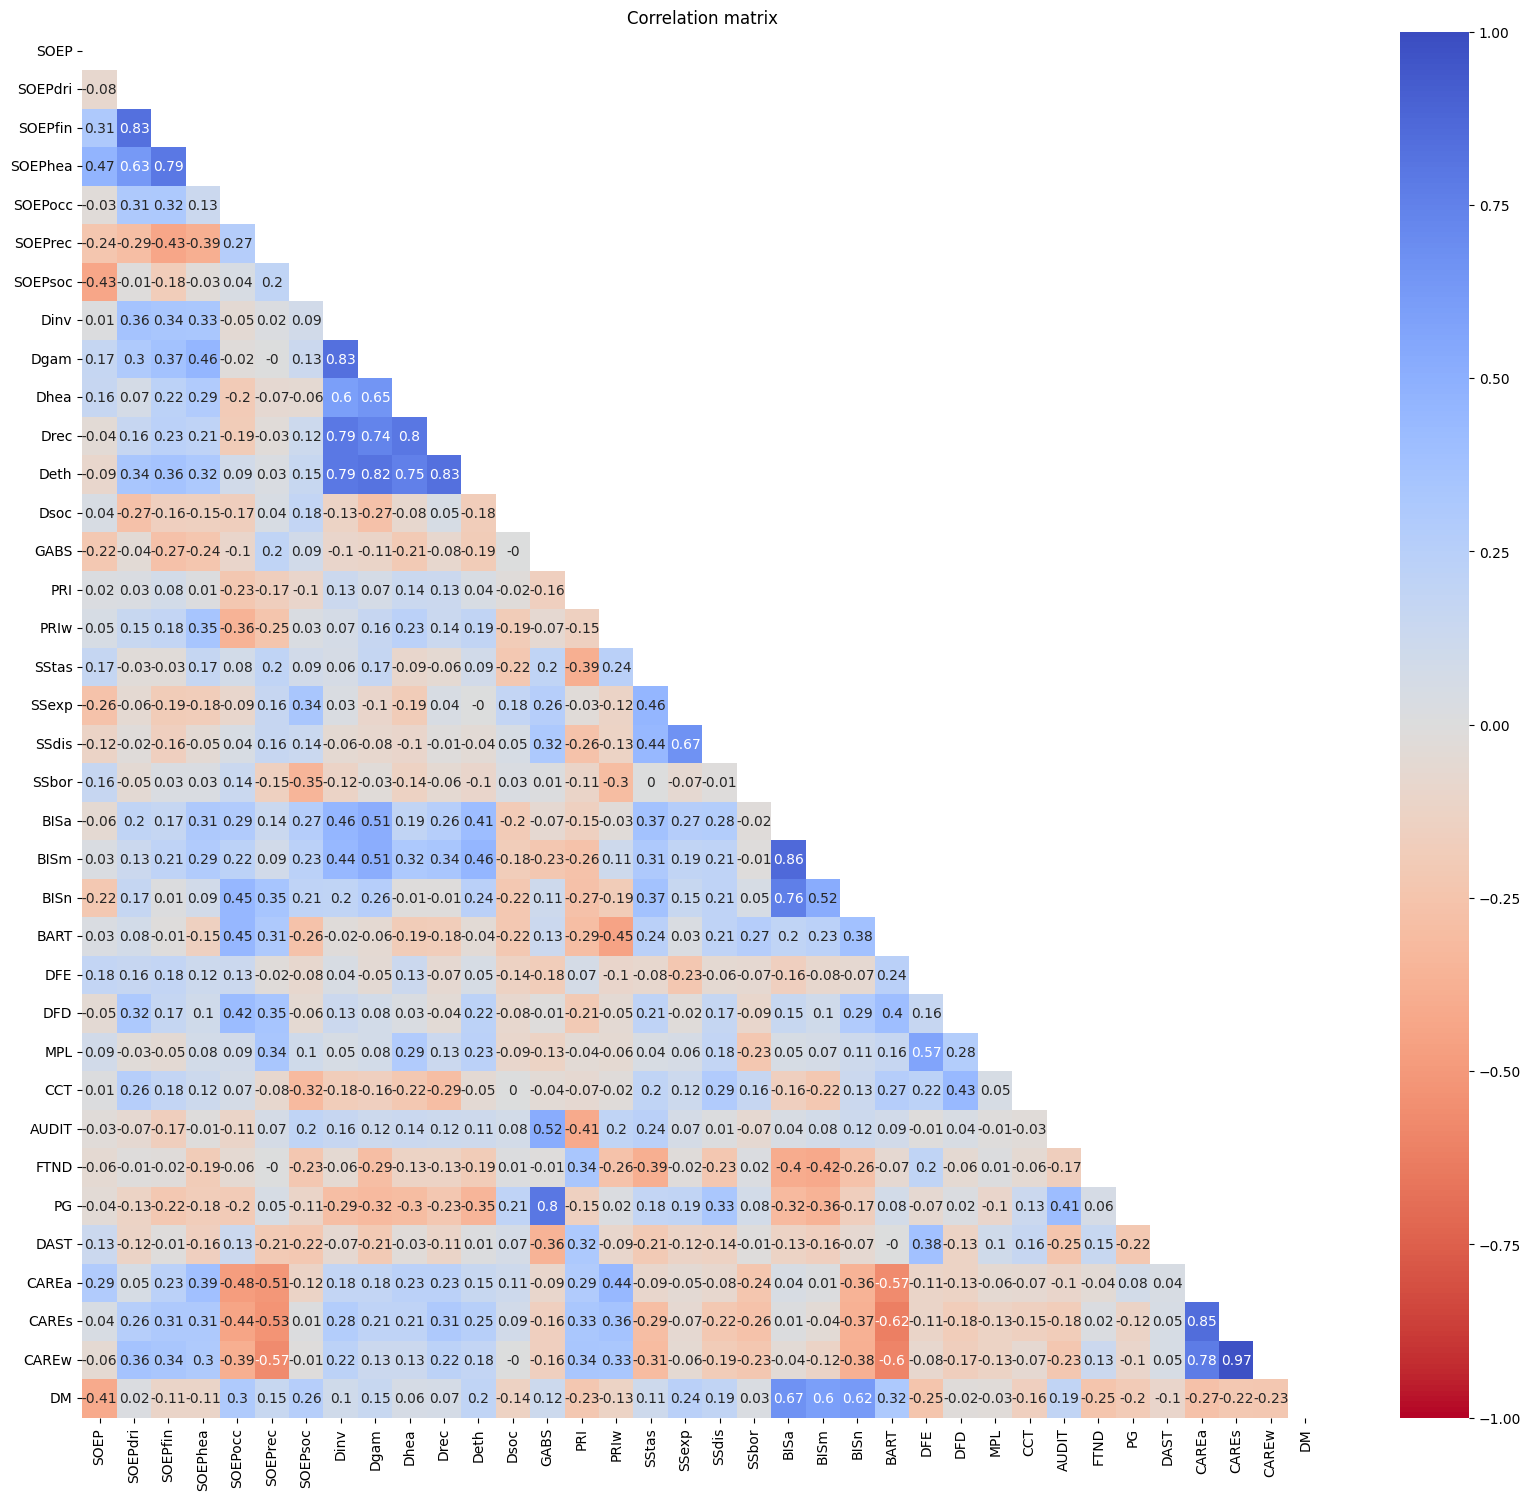

In [209]:
# Compute correlation matrix (only for numeric columns)
numeric_df = DV_data.drop(columns=['model'])
corr = numeric_df.corr().round(2)

# reorder to compare with human data
order = ['SOEP', 'SOEPdri', 'SOEPfin', 'SOEPhea', 'SOEPocc', 'SOEPrec', 'SOEPsoc',
        'Dinv', 'Dgam', 'Dhea', 'Drec', 'Deth', 'Dsoc', 'GABS', 'PRI', 'PRIw',
        'SStas', 'SSexp', 'SSdis', 'SSbor', 'BISa', 'BISm', 'BISn', 'BART', 'DFE', 'DFD', 'MPL', 'CCT', 
         'AUDIT', 'FTND', 'PG', 'DAST', 'CAREa', 'CAREs', 'CAREw', 'DM']  

corr_reordered = corr.loc[order, order].round(2)

# Display it as a heatmap
# plt.figure(figsize=(20, 18))
# sns.heatmap(corr, annot=True, cmap="coolwarm_r", vmin=-1, vmax=1)
# plt.title("Correlation matrix of model scores")
# plt.show()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_reordered, dtype=bool))

# Plot heatmap with mask
plt.figure(figsize=(20, 18))
sns.heatmap(
    corr_reordered,
    mask=mask,
    annot=True,
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1
)
plt.title("Correlation matrix")
plt.show()


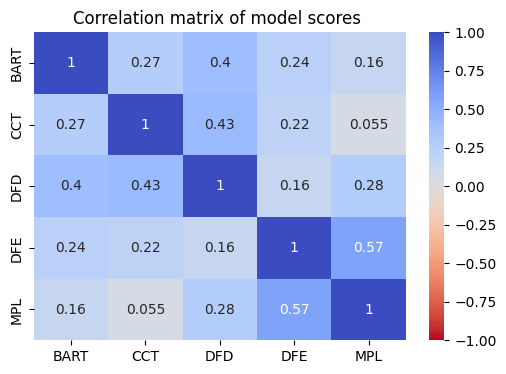

In [213]:
# Compute correlation matrix (only for numeric columns)
corr = DV_data[["BART", "CCT", "DFD", "DFE", "MPL"]].corr()

# Display it as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm_r", vmin=-1, vmax=1)
plt.title("Correlation matrix of model scores ")
plt.show()


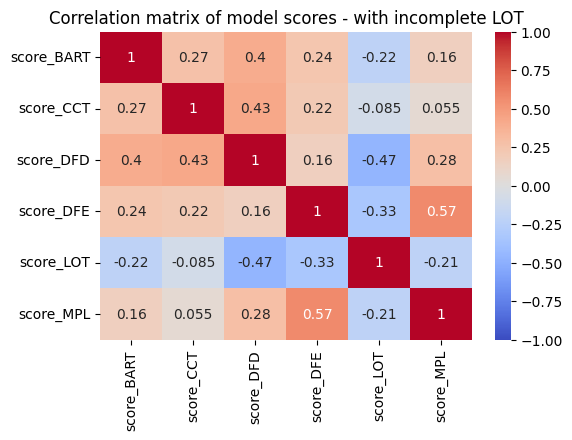

In [ ]:
# Compute correlation matrix (only for numeric columns)
corr = all_data[["score_BART", "score_CCT", "score_DFD", "score_DFE", "score_LOT", "score_MPL"]].corr()

# Display it as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of model scores - with incomplete LOT")
plt.show()


### Takes:

Overall, very low variance in the data (all models have pretty much the same values)

The correlations between the tasks is really high, though!

(Reasons??? - simple statistical reasons?)

LOT only half, but correlates negatively! Any coding errors in the LOT task that would explain that? Or in the task logic?